# Regression and Model Selection

In this notebook I will demonstrate my understanding of overfitting and underfitting using regression as an example. First I will generate a 1-dimensional feature space and an array of values for each row in the feature space. Then I will create regresion estimators based on linear regression (`x**1`) and polynomial regression (2nd, 4th and 6th degree, i.e. `x**2`, `x**4`  and `x**6`). I will show that the higher the polynomial, the better the fit for the train set, but the worse the fit for the test set. I will visually support my case.

I will re-use code from the [Python Data Science Handbook](http://bit.ly/2y3xzKw). To proof my understanding of the code I am re-using, I will comment on the code in my own words, both in MarkDown cells and in frequent code comment.

## 1. create test data

First i define a method which generates more or less random test data. The generated test data has currently one dimenssion and a seed by two.

In [4]:
import numpy as np

def make_data(N, err=1.0, rseed=2):
    # randomly sample the data, rseed is the initialization
    rng = np.random.RandomState(rseed)
    # 1 is the shape of the generated array
    X = rng.rand(N, 1) ** 2
    # generate y given by the values of X
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        # add error tolerance
        y += err * rng.randn(N)
    return X, y

X, y = make_data(400)

## 2. create the regression pipeline

as next i create a method which generates the polynomial regression calculation, based on the sklearn libaray. The formale, the calculation based on is: y=ax+b. That is for a 1D set

in the case the dimmension is bigger the degree is added by the amount.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))



## 3. show the regressors

first show the test data with several different dregrees inside a plot

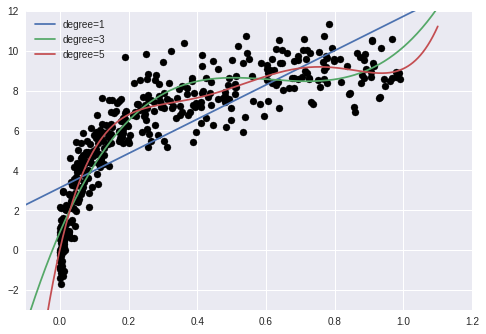

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.2)
plt.ylim(-3, 12)
plt.legend(loc='best');


## 4. show the validation curve

to check if the model has a good trade-off between bias and variance the sklearn libaray provides a validation curve. THerefore i need a method which exectues fit and predict (that is my PolynomialRegression), my test set and all possible values that should be evaluated. I will do the estimation with the degree 3.

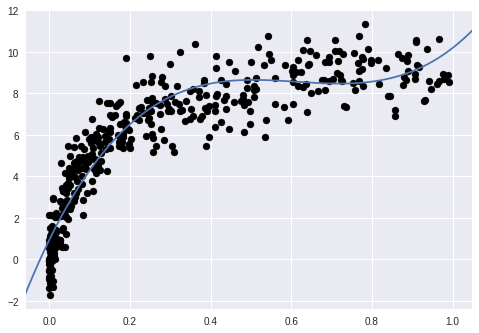

In [14]:


plt.scatter(X.ravel(), y, color='black')
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);



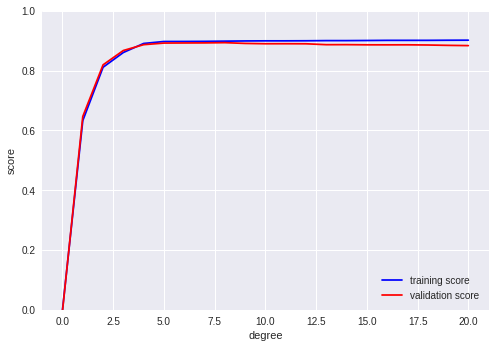

In [11]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(3), X, y,
                                          'polynomialfeatures__degree', degree)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

it can be seen that the model has a good trade-off, because the lines are quite simliar. But the best result will be by the degeree of 3

## 5. conduct grid search to find the optimal regressor

sklearn provides a grid_search libaray which do the finding of the optimal regrossor automatically, based on that running i print the factor which make the best trade-off off bias and variance

In [19]:
from sklearn.grid_search import GridSearchCV

#require a vector which explaines the amonut of degrees which should be used, 
#if should fit and intercept and if it should normalize
param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

grid.fit(X, y);

grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 8}

based on the estimation we generate a new plot with the degreee fit best to the model

/home/pia/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


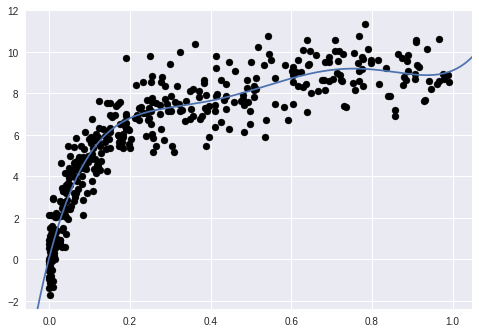

In [15]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y, color='black')
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);